# Анализ определяющих успешность игры закономерностей для компании «Стримчик»

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. <br>
В нашем распоряжении исторические данные из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы до 2016 года. <br>
Перед нами стоит задача:  нужно выявить определяющие успешность игры закономерности. <br>
Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. <br>

Перед нами данные до 2016 года. Cейчас декабрь 2016 г., и мы планируем кампанию на 2017-й <br>

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, <br>
«Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

## Шаг 1. Откроем файлы с данными и изучим общую информацию.

In [ ]:
df = pd.read_csv('/datasets/games.csv')

In [ ]:
df.info()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


0

#### Пояснение к изучению общей информации:  

Видим что в данных есть пропуски, неудобные названия столбцов (названия с заглавной буквы), дата релиза не в формате date, пользовательский рейтинг в формате object, пропуски в названии и жанре, явные дубликаты отсутсвуют.

## Шаг 2. Подготовим данные

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
df.columns= df.columns.str.lower()

# Комментарий ревьюера unknown
#df = df.dropna(subset='name').reset_index(drop=True)
df = df.dropna(subset=['name']).reset_index(drop=True)

df['year_of_release'] = df['year_of_release'].fillna(0).astype(int)
df['user_score'] = df['user_score'].replace('tbd').fillna(-1).astype('float')
df['critic_score'] = df['critic_score'].fillna(-1).astype('float')
df['rating'] = df['rating'].fillna('unknown')

df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

#### Пояснение к подготовке данных:  

Привели все названия столбцов в нижний регистр, год выпуска в формат int, заменили рейтинг "tbd" на NaN и перевели рейтинг в float. Заглушили  пропуски "-1" <br>
Пропуски в названии и жанре пусть и не значительные, но эти строки смысла не несут. <br>
Создали столбец total_sales - общая сумма продаж игр по всему миру. <br>
Остальные пропуски заполнять/заменять смысла нету. Причины возникновения пропусков: Не все игры достойны оценки критиков, не все игроки ставят оценки играм, на некоторых играх не уточнили дату резила. <br>

In [ ]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = df.copy()
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-------------------------')
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  float64
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio: Instant Artist' 'wwe Smackdown vs. Raw 2006'
 '¡Shin Chan Flipa e

## Шаг 3. Проведем исследовательский анализ данных

### Посмотрим график продаж игр по всему миру по годам.

<AxesSubplot:xlabel='Year of release', ylabel='Total sales'>

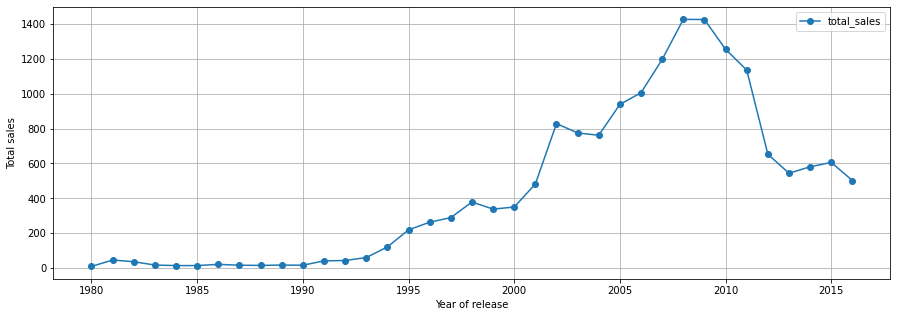

In [ ]:
df.pivot_table(index='year_of_release', values='total_sales',
               aggfunc='count').query('year_of_release != 0').plot(use_index=True,
                                                                   style='o-',
                                                                   grid=True,
                                                                   figsize=(15,5),
                                                                   xlabel='Year of release',
                                                                   ylabel='Total sales')

#### Пояснение к графику продаж по годам:  

Видим, что продажи игр начали рости с 1990 года.
На 2008-2009 приходится пик, затем наблюдается спад (можно связать это с появлением торрента и пиратских игр)

### Построим график продаж по различным платформам.

<AxesSubplot:xlabel='YEAR', ylabel='SALE m.'>

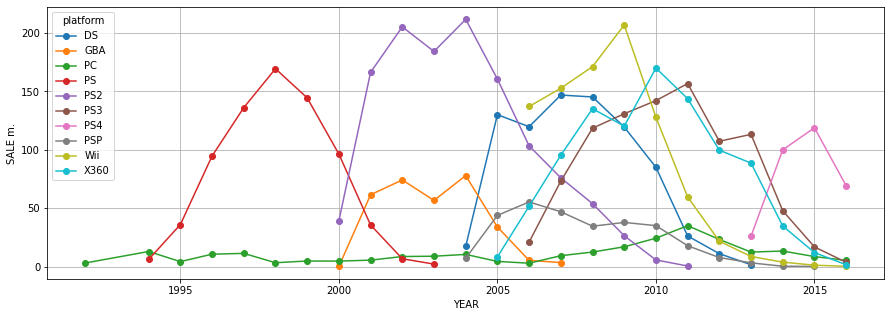

In [ ]:
top_platform = df.groupby(['platform']).agg({'total_sales': 'sum'}).sort_values(
    'total_sales', ascending=False).reset_index()['platform'].head(10)

df.query('platform in @top_platform and year_of_release > 1990 and year_of_release != 0').pivot_table(
    index='year_of_release',
    columns='platform',
    values='total_sales',
    aggfunc={'total_sales':'sum'}).plot(xlabel='YEAR',
                                        ylabel='SALE m.',
                                        style='o-',
                                        grid=True,
                                        figsize=(15,5))

#### Пояснение к графику продаж по различным платформам:
Мы выбрали платформы с наибольшими суммарными продажами (топ 10) и построили распределение по годам. <br>
За 10 лет появляются новые и исчезают старые платформы.

### Возьмем данные за актуальный период

<AxesSubplot:xlabel='YEAR', ylabel='SALE m.'>

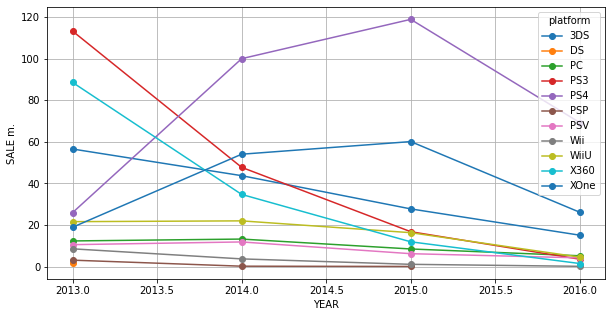

In [ ]:
actual_df = df.query('year_of_release > 2012')

actual_df.pivot_table(index='year_of_release', columns='platform',
                      values='total_sales', aggfunc={'total_sales':'sum'}).plot(xlabel='YEAR',
                                                                                ylabel='SALE m.',
                                                                                style='o-',
                                                                                grid=True,
                                                                                figsize=(10,5))

#### Пояснение к графику данные за актуальный период:
PS4, XOne а так же 3DS лидируют по объемам продаж по всему миру за последние 3 года. <br>
Эти платформы растут, данные за 2016 год не полные. <br>
Потенциально прибыльные платформы на первом месте PS4, на втором XOne.

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

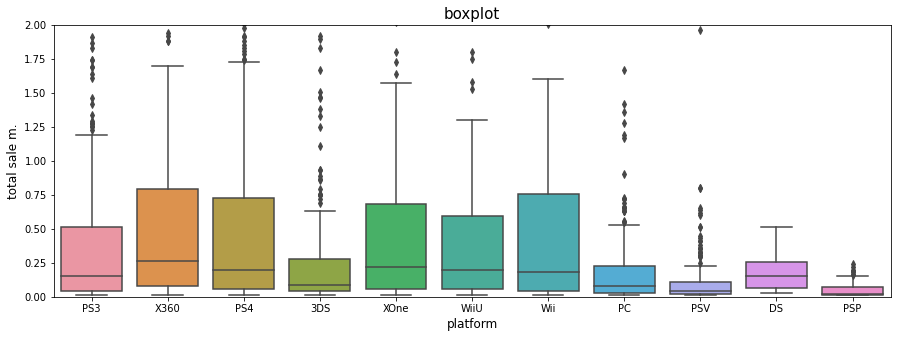

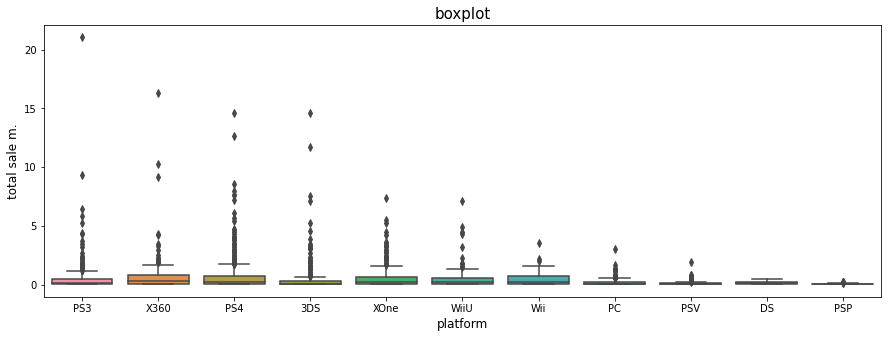

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data = actual_df, y='total_sales', x='platform')
plt.ylim(0, 2)
plt.title('boxplot', fontsize=15)
plt.xlabel('platform', fontsize=12)
plt.ylabel('total sale m.',fontsize=12)
plt.show()

plt.figure(figsize=(15,5))
sns.boxplot(data = actual_df, y='total_sales', x='platform')
plt.title('boxplot', fontsize=15)
plt.xlabel('platform', fontsize=12)
plt.ylabel('total sale m.',fontsize=12)
plt.show()

#### Пояснение и выводы по графику "ящик с усами":
За актуальный период 2013-2016 по продажам лидирует X360, но эта платформа уже себя изживает, поскольку создана была в 2005 году. <br>
На втором месте по продажам набирающая обороты PS4. <br>
На третьем месте так же изживающая себя плотформа Wii. <br>
Следом идет XOne. <br>

### Изучим влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков.

#### Построим диаграмму рассеивания

<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

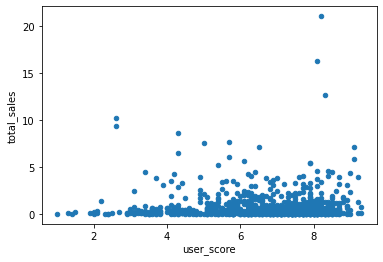

In [ ]:
actual_df.query('user_score != -1 and critic_score != -1').plot(x='user_score',
                                                                y='total_sales',
                                                                kind='scatter')

<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

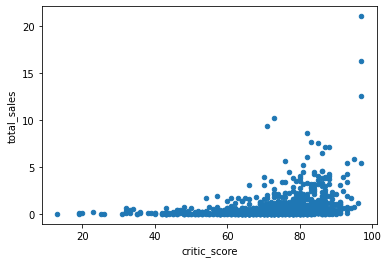

In [ ]:
actual_df.query('user_score != -1 and critic_score != -1').plot(x='critic_score',
                                                                y='total_sales',
                                                                kind='scatter')

#### Пояснение к даиграмме рассеяния:
Положительная, линейная, корреляция слабая.

### Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами для топ 5 платформ.

In [ ]:
def crate_scatter(platform):
    actual_df.query('platform == @platform and user_score != -1 \
                    and critic_score != -1').plot(x='user_score',
                    y='critic_score',kind='scatter')

def create_heatmap(platform):
    plt.figure(figsize=(7,5))
    sns.heatmap(actual_df.query('platform == @platform \
    and user_score != -1 and critic_score != -1')
                [['platform', 'critic_score', 'user_score',
                  'total_sales']].corr(), annot=True)

#### PS4

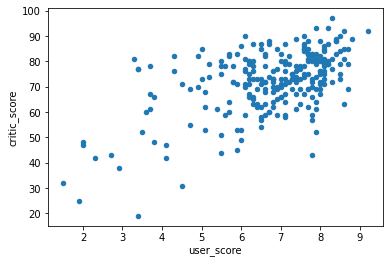

In [ ]:
crate_scatter('PS4')

##### Пояснение к даиграмме рассеяния:
Положительная, линейная, корреляция слабая

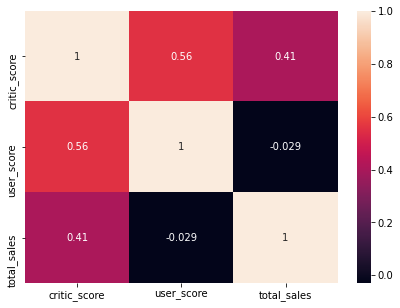

In [ ]:
create_heatmap('PS4')

#####  Пояснение к корреляции платформы PS4:
Видна положительаня корреляция между отзывами критиков и отзывами пользователей. <br>
Заметна слабая корреляция между отзывами критиков и отзывами пользователей. <br>
Корреляция между отзывами пользователей и продажами отсутсвует.

#### XOne

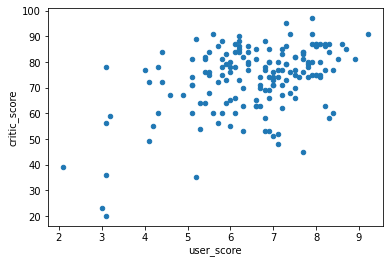

In [ ]:
crate_scatter('XOne')

##### Пояснение к даиграмме рассеяния:
Положительная, линейная, корреляция незначительная

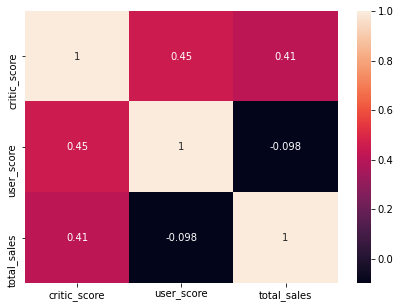

In [ ]:
create_heatmap('XOne')

#####  Пояснение к корреляции платформы XOne:
Видна положительаня корреляция между отзывами критиков и отзывами пользователей. <br>
Заметна слабая корреляция между отзывами критиков и отзывами пользователей. <br>
Корреляция между отзывами пользователей и продажами отсутсвует.

#### X360

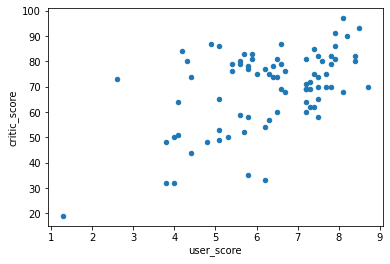

In [ ]:
crate_scatter('X360')

##### Пояснение к даиграмме рассеяния:
Положительная, линейная, слабая

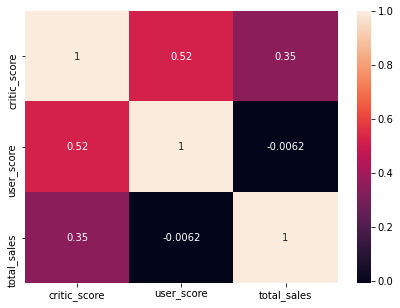

In [ ]:
create_heatmap('X360')

#####  Пояснение к корреляции платформы X360:
Видна положительаня корреляция между отзывами критиков и отзывами пользователей. <br>
Заметна слабая корреляция между отзывами критиков и отзывами пользователей. <br>
Корреляция между отзывами пользователей и продажами отсутсвует.

#### PS3

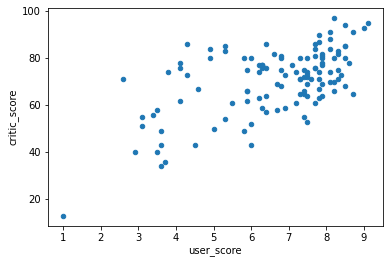

In [ ]:
crate_scatter('PS3')

##### Пояснение к даиграмме рассеяния:
Положительная, линейная, слабая

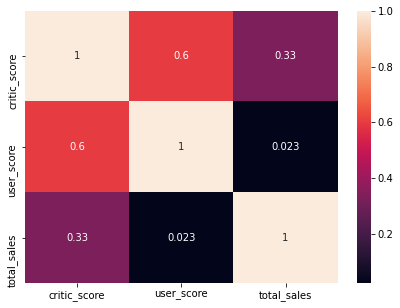

In [ ]:
create_heatmap('PS3')

#####  Пояснение к корреляции платформы PS3:
Видна положительаня корреляция между отзывами критиков и отзывами пользователей. <br>
Заметна корреляция между отзывами критиков и отзывами пользователей. <br>
Корреляция между отзывами пользователей и продажами отсутсвует.

#### 3DS

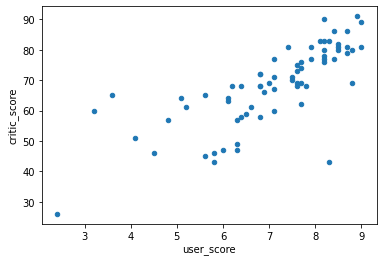

In [ ]:
crate_scatter('3DS')

##### Пояснение к даиграмме рассеяния:
Положительная, линейная, сильная

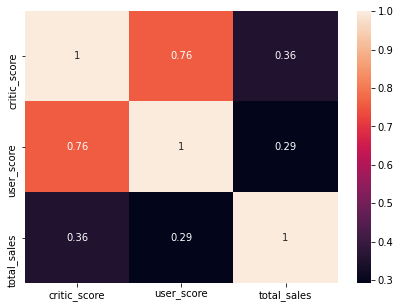

In [ ]:
create_heatmap('3DS')

#####  Пояснение к корреляции платформы 3DS:
Видна положительаня корреляция между отзывами критиков и отзывами пользователей. <br>
Заметна сильная корреляция между отзывами критиков и отзывами пользователей. <br>
Корреляция между отзывами пользователей и продажами отсутсвует.

### Соотнесите выводы с продажами игр на других платформах.

Самая сильная корреляция отзывов критиков и пользователей у 3DS

### Посмотрим на общее распределение игр по жанрам.

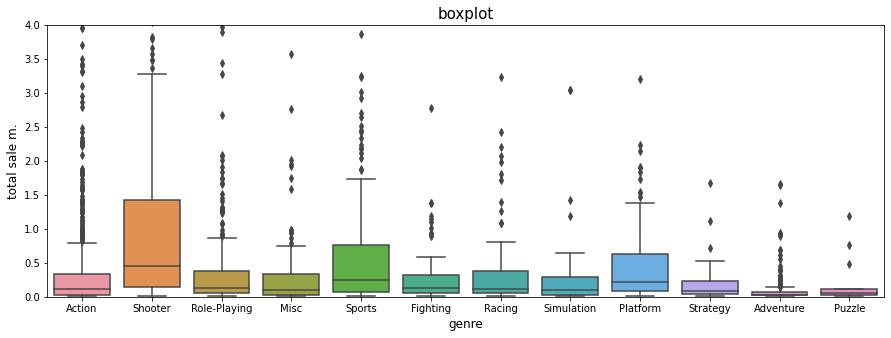

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data = actual_df, y='total_sales', x='genre')
plt.ylim(0, 4)
plt.title('boxplot', fontsize=15)
plt.xlabel('genre', fontsize=12)
plt.ylabel('total sale m.',fontsize=12)
plt.show()

#### Пояснение к общему распределению игр по жанрам:
Общее распределение игр по жанрам показывает нам устойчивый спрос на игры в жанре Shooter, Sports, platform

## Шаг 4. Составим портрет пользователя каждого региона

In [ ]:
def create_pie(index, region):
    actual_df.pivot_table(index=index,
                          values=region,
                          aggfunc='sum').sort_values(by=region,
                                                     ascending=False).plot(kind='pie',
                                                                           y=region,
                                                                           figsize=(6, 6),
                                                                           legend=False,
                                                                           autopct='%1.1f%%',
                                                                           ylabel='')

### Определим для пользователя каждого региона самые популярные платформы (топ-5)

#### Северная Америка

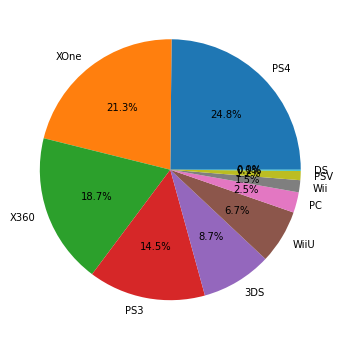

In [ ]:
create_pie('platform','na_sales')

##### Пояснение:
Большая часть продаж принадлежит платформе PS4- 25%, за нм следует XOne- 21%, затем X360- 19%, PS3- 15% и 3DS- 9%.<br>

#### Европа

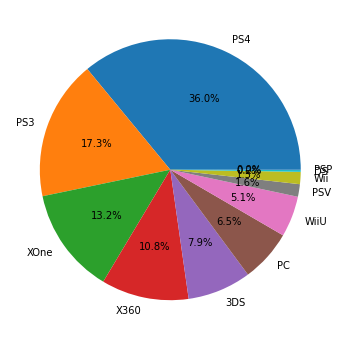

In [ ]:
create_pie('platform','eu_sales')

##### Пояснение:
Большая часть продаж принадлежит платформе PS4- 36%, за нм следует PS3- 17%, затем XOne- 13%, X360- 11% и 3DS- 8%.<br>

#### Япония

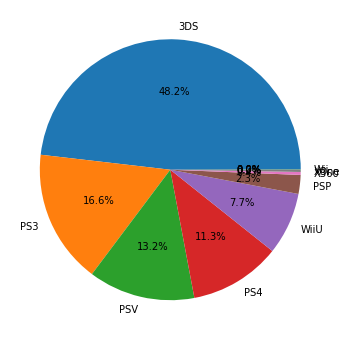

In [ ]:
create_pie('platform', 'jp_sales')

##### Пояснение:
Большая часть продаж принадлежит платформе 3DS- 48%, за нм следует PS3- 17%, затем PSV- 13%, PS4- 11% и WiiU- 8%.<br>

### Определим для пользователя каждого региона самые популярные жанры (топ-5)

#### Северная Америка

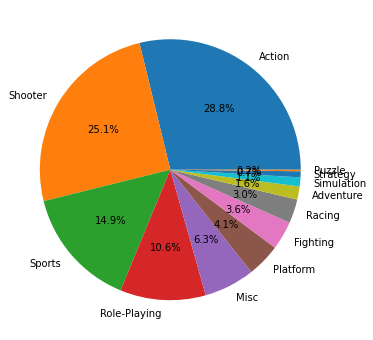

In [ ]:
create_pie('genre', 'na_sales')

##### Пояснение:
Большая часть продаж принадлежит платформе Action- 29%, за нм следует Shooter- 25%, затем Sorts- 15%, Role-Playing- 11% и Misc- 6%.<br>

#### Европа

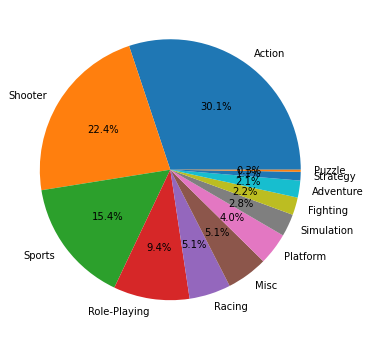

In [ ]:
create_pie('genre', 'eu_sales')

##### Пояснение:
Большая часть продаж принадлежит платформе Action- 30%, за нм следует Shooter- 22%, затем Sorts- 15%, Role-Playing- 9% и Misc- 5%.<br>

#### Япония

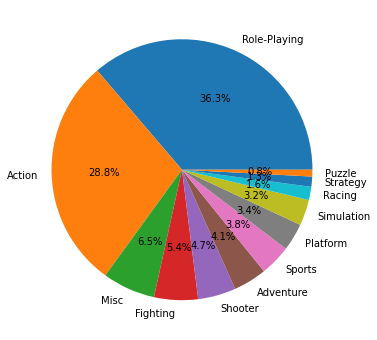

In [ ]:
create_pie('genre', 'jp_sales')

##### Пояснение:
Большая часть продаж принадлежит платформе Role-Playing- 36% за нм следует Action- 29%, затем Misc- 7%, Fighting- 5% и Shooter- 5%.<br>

### Влияние рейтинга ESRB на продажи в отдельном регионе.

#### Северная Америка

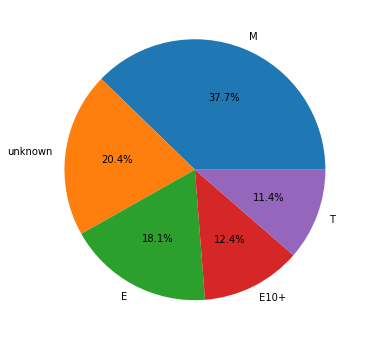

In [ ]:
create_pie('rating', 'na_sales')

##### Пояснение:
Доля продаж для рейтинга M состовляет 38%<br>

#### Европа

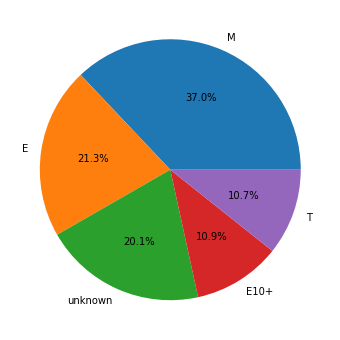

In [ ]:
create_pie('rating', 'eu_sales')

##### Пояснение:
Доля продаж для рейтинга Е состовляет 27%<br>

#### Япония

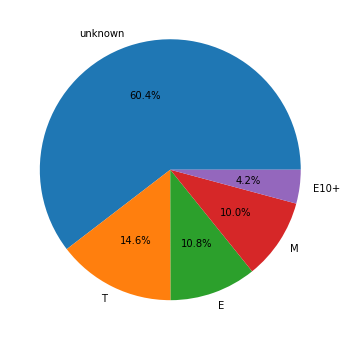

In [ ]:
create_pie('rating', 'jp_sales')

##### Пояснение:
Доля продаж для рейтинга Е состовляет 27%<br>

## Шаг 5. Проверим гипотизы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Нулевая гипотиза будет звучать так: Среднее двух генеральных совокупностей рейтинга разных платформ равны между собой. <br>
Альтернатвная гипотиза: Среднее двух генеральных совокупностей рейтинга разных платформ не равны между собой. <br>
Если pvalue будет больше альфы, гипотизу можно будет отвергнуть.

In [ ]:
alpfa = .05

results = st.ttest_ind(actual_df.query('platform =="XOne"')['user_score'],
                       actual_df.query('platform =="PC"')['user_score'])

if results.pvalue > alpfa:
    print('pvalue:', results.pvalue)
    print('Нулевая гипотиза отвергнута.')
else:
    print('pvalue:', results.pvalue)
    print('Нулевую гипотизу отвергнуть не получилось.')

pvalue: 0.24834041984468055
Нулевая гипотиза отвергнута.


#### Пояснение к первой гипотизе:
Р значение больше, чем Альфа, гипотизу о равенстве пользовательских рейтингов платформ XOne и PC- отвергаем. Не одинаковые.

### Средние пользовательские рейтинги жанров Action и Sports разные.
Нулевая гипотиза будет звучать так: Среднее двух генеральных совокупностей рейтинга разных жанров равны между собой. <br>
Альтернативная гипотиза: Среднее двух генеральных совокупностей рейтинга разных жанров не равны между собой. <br>
Если pvalue будет больше альфы, нулевую гипотизу можно будет отвергнуть.

In [ ]:
results = st.ttest_ind(actual_df.query('genre =="Action"')['user_score'],
                       actual_df.query('genre =="Sports"')['user_score'])

if results.pvalue > alpfa:
    print('pvalue:', results.pvalue)
    print('Нулевая гипотиза отвергнута.')
else:
    print('pvalue:', results.pvalue)
    print('Нулевую гипотизу отвергнуть не получилось.')

pvalue: 0.02631312035678375
Нулевую гипотизу отвергнуть не получилось.


#### Пояснение ко второй гипотизе:
Р меньше, чем Альфа, гипотизу о равенстве пользовательских рейтингов жанров Action и Sports- отвергаем. Одинаковые.

## Шаг 6. Общий вывод

В нашем распоряжении были исторические данные из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы до середины 2016 года. <br>
Перед нами стояла задача: выявить определяющие успешность игры закономерности. <br>

### По графику продаж по годам мы заметили следующее:<br>
Продажи игр начали рости с 1990 года.<br>
На 2008-2009 приходится пик, затем наблюдается спад (можно связать это с появлением торрента и пиратских игр)<br>

### По графику продаж по различным платформам мы заметили что<br>
За 10 лет появляются новые и исчезают старые платформы.<br>

### Определили актуальный период в 3 года (2012-2016)<br>
Так же выявили что PS4, XOne и 3DS лидируют по объемам продаж по всему миру за последние 3 года. <br>

Опираясь на имеющиеся данные решили что потенциально прибыльные платформы: на первом месте PS4, на втором XOne.<br>

### Сделали выводы по графику "ящик с усами":<br>
За актуальный период 2013-2016 по продажам лидирует X360, но эта платформа уже себя изживает, поскольку создана была в 2005 году. <br><br>
На втором месте по продажам набирающая обороты PS4. <br>
На третьем месте так же изживающая себя плотформа Wii. <br>
Следом идет XOne. <br>

### Построили диаграмму рассеяния <br>
Мы увидели что у PS3 самый большой разброс по количеству проданных копий, следом идет X360<br>

### Посчитали корреляцию платформы PS4 и для остальных платформ:<br>
Увидели положительную корреляцию между отзывами критиков и продажами по всему миру по PS4. <br>
Заметили слабую положительную корреляцию между отзывами критиков и продажами по всему миру по всем остальным платформам. <br>
Корреляция между отзывами пользователей и продажами отсутсвует. <br>
Сделали вывод о том что у платформы PS4 положительная зависимость между оценками критиков и продажами выше.<br>

### Сделали распределение игр по жанрам <br>
Мы поняли что большая часть продаж принадлежит жанру Action 30%, за нм следует Shooter 21%, затем Sports 14%, и Role-Playing 13%.<br>
### Сделали портреты для пользователей каждого региона:<br>
Определили топ популярных платформ в регионах:<br>
Для Северной Америки большая часть продаж принадлежит платформе PS4- 25%, за нм следует XOne- 21%, затем X360- 19%, PS3- 15% и 3DS- 9%.<br>
Для Европы большая часть продаж принадлежит платформе PS4- 36%, за нм следует PS3- 17%, затем XOne- 13%, X360- 11% и 3DS- 8%.<br>
Для Японии большая часть продаж принадлежит платформе 3DS- 48%, за нм следует PS3- 17%, затем PSV- 13%, PS4- 11% и WiiU- 8%.<br>

###  Определили топ популярных жанров игр в регионах:<br>
Для Северной Америки большая часть продаж принадлежит платформе Action- 29%, за нм следует Shooter- 25%, затем Sorts- 15%, Role-Playing- 11% и Misc- 6%.<br>
Для Европы большая часть продаж принадлежит платформе Action- 30%, за нм следует Shooter- 22%, затем Sorts- 15%, Role-Playing- 9% и Misc- 5%.<br>
Для Японии большая часть продаж принадлежит платформе Role-Playing- 36% за нм следует Action- 29%, затем Misc- 7%, Fighting- 5% и Shooter- 5%.<br>

###  Проверили гипотизы:<br>

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.<br>
Средние пользовательские рейтинги жанров Action и Sports разные.<br>
Обе отвергли. <br>

### Возвращаясь к вопросу о выявлении определяющих успешность игры закономерностей
Для Северной Америки PS4, Action, M <br>
Для Европы PS4, Action, M <br>
Для Японии 3DS, Role-Playing, T <br>
По миру устойчивый спрос на Shooter, Sports, Platform. <br>
Отзывы критиков слабо, но влияют на продажи. <br>
Отзывы пользователей никак не влияют <br>